来看一个实例，我们将重点讨论猫狗图像分类，数据集中包含 4000张猫和狗的图像（2000张猫的图像，2000张狗的图像）。我们将   2000张图像用于训练，1000张用于验证，1000张用于测试。   

本节将介绍解决这一问题的基本策略，即使用已有的少量数据从头开始训练一个新模型。首先，在 2000个训练样本上训练一个简单的小型卷积神经网络，不做任何正则化，为模型目标设定一个基准。这会得到 71%的分类精度。此时主要的问题在于过拟合。然后，我们会介绍数据增强（data augmentation），它在计算机视觉领域是一种非常强大的降低过拟合的技术。使用数据增强之后，网络精度将提高到 82%。

5.3节会介绍将深度学习应用于小型数据集的另外两个重要技巧：用预训练的网络做特征提取（得到的精度范围在  90%~96%），对预训练的网络进行微调（最终精度为  97%）。总而言之，这三种策略——从头开始训练一个小型模型、使用预训练的网络做特征提取、对预训练的网络进行微调——构成了你的工具箱，未来可用于解决小型数据集的图像分类问题。

### 5.2.1　深度学习与小数据问题的相关性
有时你会听人说，仅在有大量数据可用时，深度学习才有效。这种说法部分正确：深度学习的一个基本特性就是能够独立地在训练数据中找到有趣的特征，无须人为的特征工程，而这只在拥有大量训练样本时才能实现。对于输入样本的维度非常高（比如图像）的问题尤其如此。

但对于初学者来说，所谓“大量”样本是相对的，即相对于你所要训练网络的大小和深度而言。只用几十个样本训练卷积神经网络就解决一个复杂问题是不可能的，但如果模型很小，并做了很好的正则化，同时任务非常简单，那么几百个样本可能就足够了。由于卷积神经网络学到的是局部的、平移不变的特征，它对于感知问题可以高效地利用数据。虽然数据相对较少，但在非常小的图像数据集上从头开始训练一个卷积神经网络，仍然可以得到不错的结果，而且无须任何自定义的特征工程。本节你将看到其效果。

此外，深度学习模型本质上具有高度的可复用性，比如，已有一个在大规模数据集上训练的图像分类模型或语音转文本模型，你只需做很小的修改就能将其复用于完全不同的问题。特别是在计算机视觉领域，许多预训练的模型（通常都是在    ImageNet数据集上训练得到的）现在都可以公开下载，并可以用于在数据很少的情况下构建强大的视觉模型。这是  5.3节的内容。我们先来看一下数据。

### 5.2.2　下载数据
本节用到的猫狗分类数据集不包含在   Keras中。它由  Kaggle在  2013年末公开并作为一项计算视觉竞赛的一部分，当时卷积神经网络还不是主流算法。你可以从   https://www.kaggle.com/c/dogs-vs-cats/data下载原始数据集（如果没有   Kaggle账号的话，你需要注册一个，别担心，很简单）。

这些图像都是中等分辨率的彩色 JPEG图像。图  5-8给出了一些样本示例。

In [35]:
import os, shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [11]:
orignial_dataset_dir='/Users/yihuawang/Deeplearning/dogs-vs-cats/train/'
base_dir='/Users/yihuawang/Deeplearning/cats_and_dogs_small' #保存较小数据集的目录
os.mkdir(base_dir)

train_dir=os.path.join(base_dir,'train') #训练数据集目录
os.mkdir(train_dir)

validation_dir=os.path.join(base_dir,'validation') #验证数据集目录
os.mkdir(validation_dir)

test_dir=os.path.join(base_dir,'test') #测试数据集目录
os.mkdir(test_dir)

train_cats_dir=os.path.join(train_dir,'cats') # train_cats
os.mkdir(train_cats_dir)

train_dogs_dir=os.path.join(train_dir,'dogs') # train_dogs
os.mkdir(train_dogs_dir)

validation_cats_dir=os.path.join(validation_dir,'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir=os.path.join(validation_dir,'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir=os.path.join(test_dir,'cats')
os.mkdir(test_cats_dir)

test_dogs_dir=os.path.join(test_dir,'dogs')
os.mkdir(test_dogs_dir)

In [18]:

# 将前1000张猫的图像复制到train_cats_dir
fnames=['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src=os.path.join(orignial_dataset_dir,fname)
    dst=os.path.join(train_cats_dir,fname)
    shutil.copyfile(src,dst)

# 将接下来500张猫的图像复制到validation_cats_dir
fnames=['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src=os.path.join(orignial_dataset_dir,fname)
    dst=os.path.join(validation_cats_dir,fname)
    shutil.copyfile(src,dst)
    
# 将接下来500张猫的图像复制到test_cats_dir
fnames=['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src=os.path.join(orignial_dataset_dir,fname)
    dst=os.path.join(test_cats_dir,fname)
    shutil.copyfile(src,dst)
    
# 将前1000张狗的图像复制到train_dogs_dir
fnames=['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src=os.path.join(orignial_dataset_dir,fname)
    dst=os.path.join(train_dogs_dir,fname)
    shutil.copyfile(src,dst)

# 将接下来500张狗的图像复制到validation_dogs_dir
fnames=['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src=os.path.join(orignial_dataset_dir,fname)
    dst=os.path.join(validation_dogs_dir,fname)
    shutil.copyfile(src,dst)
    
# 将接下来500张狗的图像复制到test_cats_dir
fnames=['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src=os.path.join(orignial_dataset_dir,fname)
    dst=os.path.join(test_dogs_dir,fname)
    shutil.copyfile(src,dst)



In [19]:
# 检查各组分别包含多少张图像

print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


### 5.2.3　构建网络

在前一个  MNIST示例中，我们构建了一个小型卷积神经网络，所以你应该已经熟悉这种网络。我们将复用相同的总体结构，即卷积神经网络由   Conv2D层（使用 relu激活）和MaxPooling2D层交替堆叠构成。

但由于这里要处理的是更大的图像和更复杂的问题，你需要相应地增大网络，即再增加一个Conv2D+MaxPooling2D的组合。这既可以增大网络容量，也可以进一步减小特征图的尺寸，使其在连接 Flatten层时尺寸不会太大。本例中初始输入的尺寸为   150×150（有些随意的选择），所以最后在Flatten层之前的特征图大小为   7×7。   

网络中特征图的深度在逐渐增大（从   32增大到  128），而特征图的尺寸在逐渐减小（从150×150减小到  7×7）。这几乎是所有卷积神经网络的模式。

你面对的是一个二分类问题，所以网络最后一层是使用 sigmoid激活的单一单元（大小为1的Dense层）。这个单元将对某个类别的概率进行编码。



In [21]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 5.2.4　数据预处理
你现在已经知道，将数据输入神经网络之前，应该将数据格式化为经过预处理的浮点数张量。现在，数据以 JPEG文件的形式保存在硬盘中，所以数据预处理步骤大致如下。

(1)读取图像文件。

(2)将  JPEG文件解码为  RGB像素网格。

(3)将这些像素网格转换为浮点数张量。

(4)将像素值（0~255范围内）缩放到   [0, 1]区间（正如你所知，神经网络喜欢处理较小的输入值）。

这些步骤可能看起来有点吓人，但幸运的是，  Keras拥有自动完成这些步骤的工具。  Keras有一个图像处理辅助工具的模块，位于keras.preprocessing.image。特别地，它包含ImageDataGenerator类，可以快速创建   Python生成器，能够将硬盘上的图像文件自动转换为预处理好的张量批量。下面我们将用到这个类。

In [61]:
train_datagen= ImageDataGenerator(rescale= 1./255) #将所有图像乘以 1/255
test_datagen= ImageDataGenerator(rescale= 1./255)


train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150), #将所有图像的大小调整为150*150
    batch_size=20,
    class_mode='binary') #因为使用了binary_crossentropy损失，所以需要用二进制标签

validation_generator= test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [55]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


In [62]:
#利用批量生成器拟合模型
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

100/100 [==============================] - 36s 363ms/step - loss: 0.5605 - acc: 0.7115 - val_loss: 0.5759 - val_acc: 0.7000


In [29]:
# 保存模型
model.save('cats_and_dogs_small_1.h5')

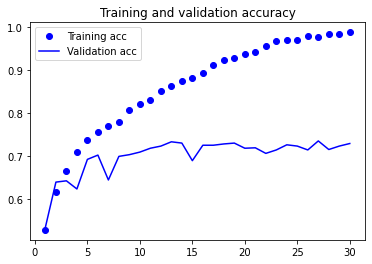

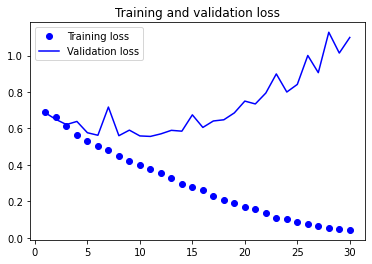

In [30]:
# 绘制训练过程中的损失曲线和精度曲线
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

从这些图像中都能看出过拟合的特征。训练精度随着时间线性增加，直到接近 100%，而验证精度则停留在 70%~72%。验证损失仅在 5轮后就达到最小值，然后保持不变，而训练损失则一直线性下降，直到接近于 0。

因为训练样本相对较少（ 2000个），所以过拟合是你最关心的问题。前面已经介绍过几种降低过拟合的技巧，比如  dropout和权重衰减（  L2正则化）。现在我们将使用一种针对于计算机视觉领域的新方法，在用深度学习模型处理图像时几乎都会用到这种方法，   
它就是数据增强（data augmentation）。

### 5.2.5　使用数据增强
过拟合的原因是学习样本太少，导致无法训练出能够泛化到新数据的模型。如果拥有无限的数据，那么模型能够观察到数据分布的所有内容，这样就永远不会过拟合。数据增强是从现有的训练样本中生成更多的训练数据，其方法是利用多种能够生成可信图像的随机变换来增加（augment）样本。其目标是，模型在训练时不会两次查看完全相同的图像。这让模型能够观察到数据的更多内容，从而具有更好的泛化能力。

In [31]:
# 利用ImageDataGenerator来设置数据增强
datagen = ImageDataGenerator(
      rotation_range=40, #rotation_range是角度值（在   0~180范围内），表示图像随机旋转的角度范围。
      width_shift_range=0.2, #width_shift和height_shift是图像在水平或垂直方向上平移的范围（相对于总宽度或总高度的比例）
      height_shift_range=0.2,
      shear_range=0.2, #shear_range是随机错切变换的角度。
      zoom_range=0.2, #zoom_range是图像随机缩放的范围。
      horizontal_flip=True, #horizontal_flip是随机将一半图像水平翻转。如果没有水平不对称的假设（比如真实世界的图像），这种做法是有意义的。
      fill_mode='nearest') #fill_mode是用于填充新创建像素的方法，这些新像素可能来自于旋转或宽度/高度平移。

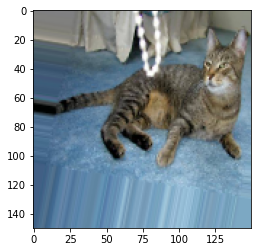

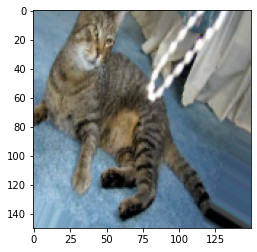

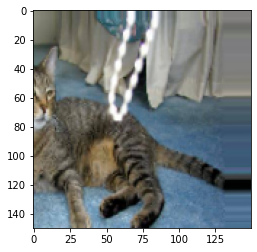

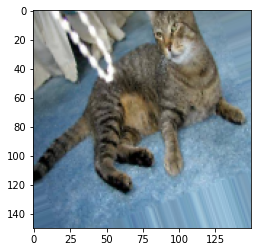

In [37]:
# 显示几个随机增强后的训练图像

fnames= [os.path.join(train_cats_dir,fname) for fname in os.listdir(train_cats_dir)]

img_path=fnames[3] #选择第四张图像进行加强
img= image.load_img(img_path, target_size=(150,150)) # 读取图像并调整大小
x= image.img_to_array(img) # 将其调整为 (150,150,3)的Numpy数组
x= x.reshape((1,)+x.shape) #将其形状改变为(1,150,150,3)

i=0

for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot=plt.imshow(image.array_to_img(batch[0]))
    i +=1
    if i % 4 ==0:
        break
plt.show()

如果你使用这种数据增强来训练一个新网络，那么网络将不会两次看到同样的输入。但网络看到的输入仍然是高度相关的，因为这些输入都来自于少量的原始图像。你无法生成新信息，而只能混合现有信息。因此，这种方法可能不足以完全消除过拟合。为了进一步降低过拟合，你还需要向模型中添加一个Dropout层，添加到密集连接分类器之前。

In [38]:
#定义一个包含 dropout的新卷积神经网络
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # 就是在训练过程中随机将该层的一些输出特征舍弃
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [59]:

train_datagen.shape

AttributeError: 'ImageDataGenerator' object has no attribute 'shape'

In [64]:
# 利用数据增强生成器训练卷积神经网络
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255) # 注意，不能增强验证数据


train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150), #将所有图像的大小调整为150*150
    batch_size=20,
    class_mode='binary') #因为使用了binary_crossentropy损失，所以需要用二进制标签

validation_generator= test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

history=model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 34s 338ms/step - loss: 0.5992 - acc: 0.6830 - val_loss: 0.6026 - val_acc: 0.6630
Epoch 2/100
100/100 [==============================] - 34s 338ms/step - loss: 0.5863 - acc: 0.6900 - val_loss: 0.5840 - val_acc: 0.6810
Epoch 3/100
100/100 [==============================] - 34s 337ms/step - loss: 0.5767 - acc: 0.7030 - val_loss: 0.5656 - val_acc: 0.7020
Epoch 4/100
100/100 [==============================] - 36s 356ms/step - loss: 0.5768 - acc: 0.6890 - val_loss: 0.5521 - val_acc: 0.7060
Epoch 5/100
100/100 [==============================] - 35s 346ms/step - loss: 0.5783 - acc: 0.7010 - val_loss: 0.5369 - val_acc: 0.7240
Epoch 6/100
100/100 [==============================] - 35s 346ms/step - loss: 0.5763 - acc: 0.6965 - val_loss: 0.6218 - val_acc: 0.6580
Epoch 7/100
100/100 [==============================] - 34s 339ms/step - loss: 0.5623 - acc: 0.7005 -

100/100 [==============================] - 35s 349ms/step - loss: 0.4249 - acc: 0.8025 - val_loss: 0.4192 - val_acc: 0.8070
Epoch 61/100
100/100 [==============================] - 34s 339ms/step - loss: 0.4373 - acc: 0.7885 - val_loss: 0.5061 - val_acc: 0.7780
Epoch 62/100
100/100 [==============================] - 34s 338ms/step - loss: 0.4084 - acc: 0.8090 - val_loss: 0.4808 - val_acc: 0.7890
Epoch 63/100
100/100 [==============================] - 34s 339ms/step - loss: 0.4295 - acc: 0.8080 - val_loss: 0.4814 - val_acc: 0.7750
Epoch 64/100
100/100 [==============================] - 34s 339ms/step - loss: 0.4159 - acc: 0.8090 - val_loss: 0.4755 - val_acc: 0.7850
Epoch 65/100
100/100 [==============================] - 34s 343ms/step - loss: 0.4286 - acc: 0.8055 - val_loss: 0.4610 - val_acc: 0.7930
Epoch 66/100
100/100 [==============================] - 34s 344ms/step - loss: 0.4234 - acc: 0.8030 - val_loss: 0.4481 - val_acc: 0.7970
Epoch 67/100
100/100 [==============================] 

In [65]:
model.save('cats_and_dogs_small_2.h5')

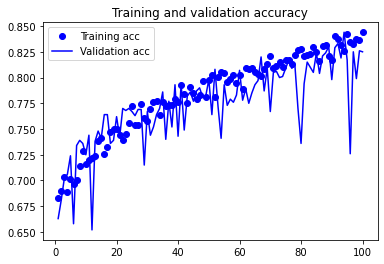

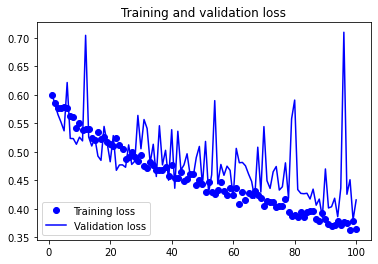

In [66]:
# 绘制训练过程中的损失曲线和精度曲线
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

通过进一步使用正则化方法以及调节网络参数（比如每个卷积层的过滤器个数或网络中的层数），你可以得到更高的精度，可以达到86%或87%。但只靠从头开始训练自己的卷积神经网络，再想提高精度就十分困难，因为可用的数据太少。想要在这个问题上进一步提高精度，下一步需要使用预训练的模型，这是接下来两节的重点。